In [1]:
import matplotlib.pyplot as plt
import seaborn 
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, to_tree
from scipy.spatial.distance import pdist
import networkx as nx

In [2]:
# cd embedding/

/Users/satyaki/ND/research/embedding


In [3]:
np.set_printoptions(precision=5, suppress=True)

### Read embedding

In [197]:
# df = pd.read_csv('g1.emb', sep=' ', header=None, names=['node', 'x'])
# df = pd.read_csv('g1_128.emb', sep=' ', header=None)
# df = pd.read_csv('g2.emb', sep=' ', header=None)
df = pd.read_csv('dummy.emb', sep=' ', header=None)

In [198]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,6,0.003643,-0.103823,0.005158,0.032265,0.072231,-0.078176,0.087677,0.223092,0.086880,...,-0.112250,0.011426,-0.062141,-0.056455,-0.012936,-0.264616,-0.249197,0.075791,0.263238,0.095771
1,9,0.001485,-0.101634,0.000083,0.024311,0.069899,-0.077510,0.084237,0.211882,0.087096,...,-0.109328,0.013377,-0.063114,-0.054366,-0.016210,-0.250725,-0.236354,0.076125,0.247469,0.098381
2,2,0.004253,-0.100922,0.003598,0.021526,0.067285,-0.075909,0.084325,0.202718,0.074589,...,-0.105555,0.007010,-0.060844,-0.053472,-0.013847,-0.246051,-0.221112,0.073099,0.239066,0.093342
3,5,0.001902,-0.107102,-0.000768,0.023198,0.073931,-0.080352,0.088012,0.204305,0.087089,...,-0.103538,0.010810,-0.061618,-0.050321,-0.015314,-0.254296,-0.234616,0.075840,0.241316,0.100737
4,3,-0.002601,-0.099831,0.008253,0.022843,0.070471,-0.077953,0.084912,0.203399,0.074869,...,-0.101219,0.008533,-0.062135,-0.055120,-0.017957,-0.246072,-0.227896,0.073193,0.239281,0.096647


In [199]:
# convert it to a matrix
mat = df.as_matrix()

In [200]:
mat[:,1:]

array([[ 0.00364, -0.10382,  0.00516, ...,  0.07579,  0.26324,  0.09577],
       [ 0.00148, -0.10163,  0.00008, ...,  0.07613,  0.24747,  0.09838],
       [ 0.00425, -0.10092,  0.0036 , ...,  0.0731 ,  0.23907,  0.09334],
       ...,
       [ 0.00536, -0.10275,  0.00405, ...,  0.06774,  0.2516 ,  0.09303],
       [ 0.00786, -0.09914, -0.00092, ...,  0.06899,  0.24934,  0.09801],
       [-0.00037, -0.09847,  0.00466, ...,  0.07491,  0.24355,  0.09839]])

## Pick a method of hierarchical clustering

In [225]:
for method in ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']:
    Z = linkage(mat[:, 1:], method)
    c, coph_dist = cophenet(Z, pdist(mat[:, 1:]))
    print(method, c)
# Z = linkage(mat[:, 1:], 'average')

single 0.7298395158449347
complete 0.5248718424323267
average 0.7796479038877377
weighted 0.7795345614454501
centroid 0.7692896518863451
median 0.7391600855291954
ward 0.5651314427887442


In [226]:
Z[:10, :]

array([[ 6.     ,  7.     ,  0.03639,  2.     ],
       [ 2.     ,  4.     ,  0.03915,  2.     ],
       [ 1.     ,  3.     ,  0.04218,  2.     ],
       [ 8.     , 11.     ,  0.0433 ,  3.     ],
       [ 5.     , 10.     ,  0.04965,  3.     ],
       [ 9.     , 12.     ,  0.05503,  5.     ],
       [13.     , 14.     ,  0.06588,  8.     ],
       [ 0.     , 15.     ,  0.09298,  9.     ]])

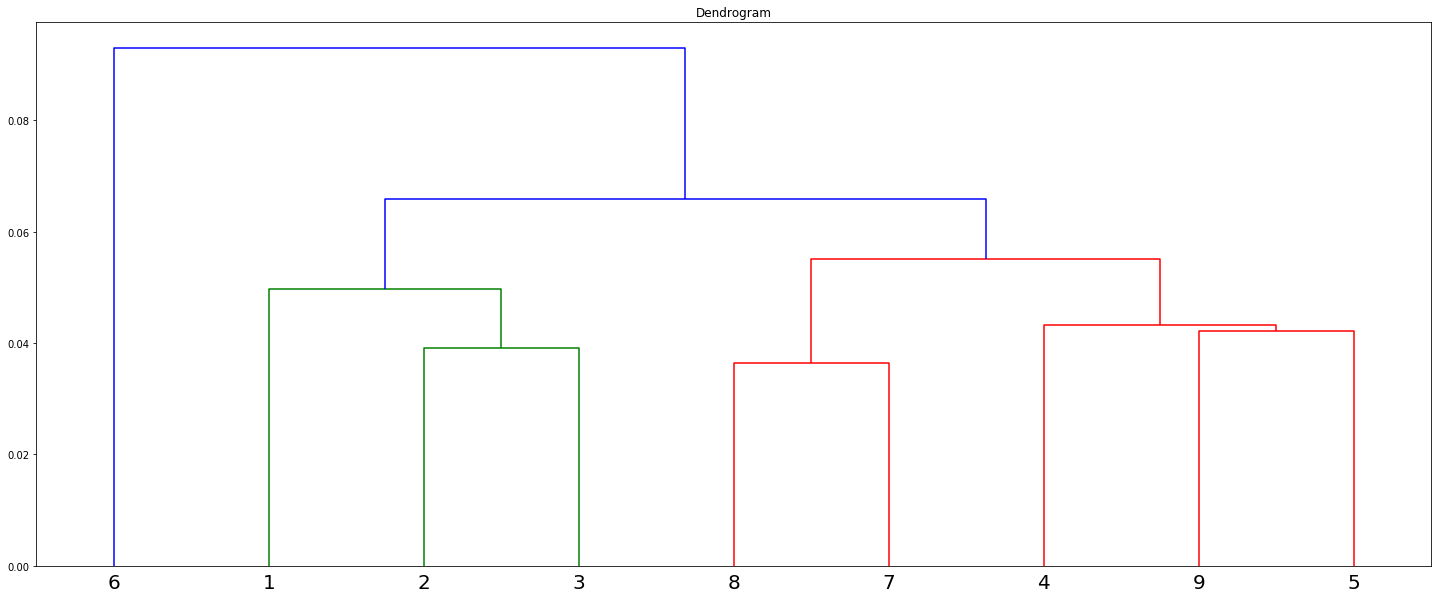

In [227]:
plt.figure(figsize=(25, 10))
plt.title('Dendrogram')

dendrogram(
    Z,
#     leaf_rotation=90,
    leaf_font_size=20,
    labels=list(map(lambda x: str(int(x)), mat[:, 0])),
    show_leaf_counts=True,
    count_sort=True
)
# plt.savefig('dendro_g1.png')
plt.show()


### Read edgelist

In [228]:
# G = nx.read_edgelist('lfr_48.txt', nodetype=int)
G = nx.read_edgelist('dummy.txt', nodetype=int)

## Find the spanning nodes and edges

In [243]:
labels = {i: int(lab) for i, lab in enumerate(mat[:, 0])}
clusters_list = [] #list of dictionary of clusters 
clusters_list.append({v: (set([v]), None) for k, v in labels.items()}) # set of nodes, and set of edges spanning two children
# print(clusters_list)

for i, row in enumerate(Z):
    ix1, ix2 = map(int, row[: 2])
    d, num = row[-2: ]
    
    if ix1 < G.order():
        ix1 = labels[ix1]
    else:
        ix1 = 'C_{}'.format(ix1)
        
    if ix2 < G.order():
        ix2 = labels[ix2]
    else:
        ix2 = 'C_{}'.format(ix2)
    
    clusters = clusters_list[i].copy()

    clu1 = clusters[ix1][0]
    clusters.pop(ix1)

    clu2 = clusters[ix2][0]
    clusters.pop(ix2)
    
    clu = clu1 | clu2
    spanning_edges = set(nx.edge_boundary(G, clu1, clu2))
    spanning_nodes = set(nx.node_boundary(G, clu1, clu2))
    clusters['C_{}'.format(G.order()+i)] = (clu, spanning_edges)
    print(clu1, clu2, spanning_edges, len(spanning_nodes) - 1)#'C_{}'.format(G.order()+i), sorted(clu))
    print()
    clusters_list.append(clusters)
clusters_list.reverse()

{8} {7} {(8, 7)} 0

{2} {3} {(2, 3)} 0

{9} {5} set() -1

{4} {9, 5} {(4, 5)} 0

{1} {2, 3} {(1, 2)} 0

{8, 7} {9, 4, 5} {(8, 9), (7, 9)} 0

{1, 2, 3} {4, 5, 7, 8, 9} {(1, 4), (1, 5), (3, 9), (2, 5), (3, 4), (3, 5)} 2

{6} {1, 2, 3, 4, 5, 7, 8, 9} {(6, 9), (6, 2), (6, 7), (6, 8)} 3

